[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import json
from jax import grad,value_and_grad

/tmp/ipykernel_2304747/2473102757.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Import the geometry, mesh and fixed node info
f = open('Neumunster.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)


f.close()

df = data['faces'] #Connectivity matrix
faces = np.array(df) #convert to numpy array
df2 = data['vertices'] #Coordinate
crd = np.array(df2) #convert to numpy array
df3 = data['vertex_is_red'] #Connectivity matrix
fixed_nodes = np.where(df3)[0] #convert to numpy array

#From faces to frames
import trimesh
mesh = trimesh.load('Neumunster.ply')

cnct  = np.array(mesh.edges_unique)

In [61]:
#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]-min(crd[:,2])

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

In [62]:
design_nodes = [] 
for i in range(n_node):
  if i not in fixed_nodes:
    design_nodes.append(i)

fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))

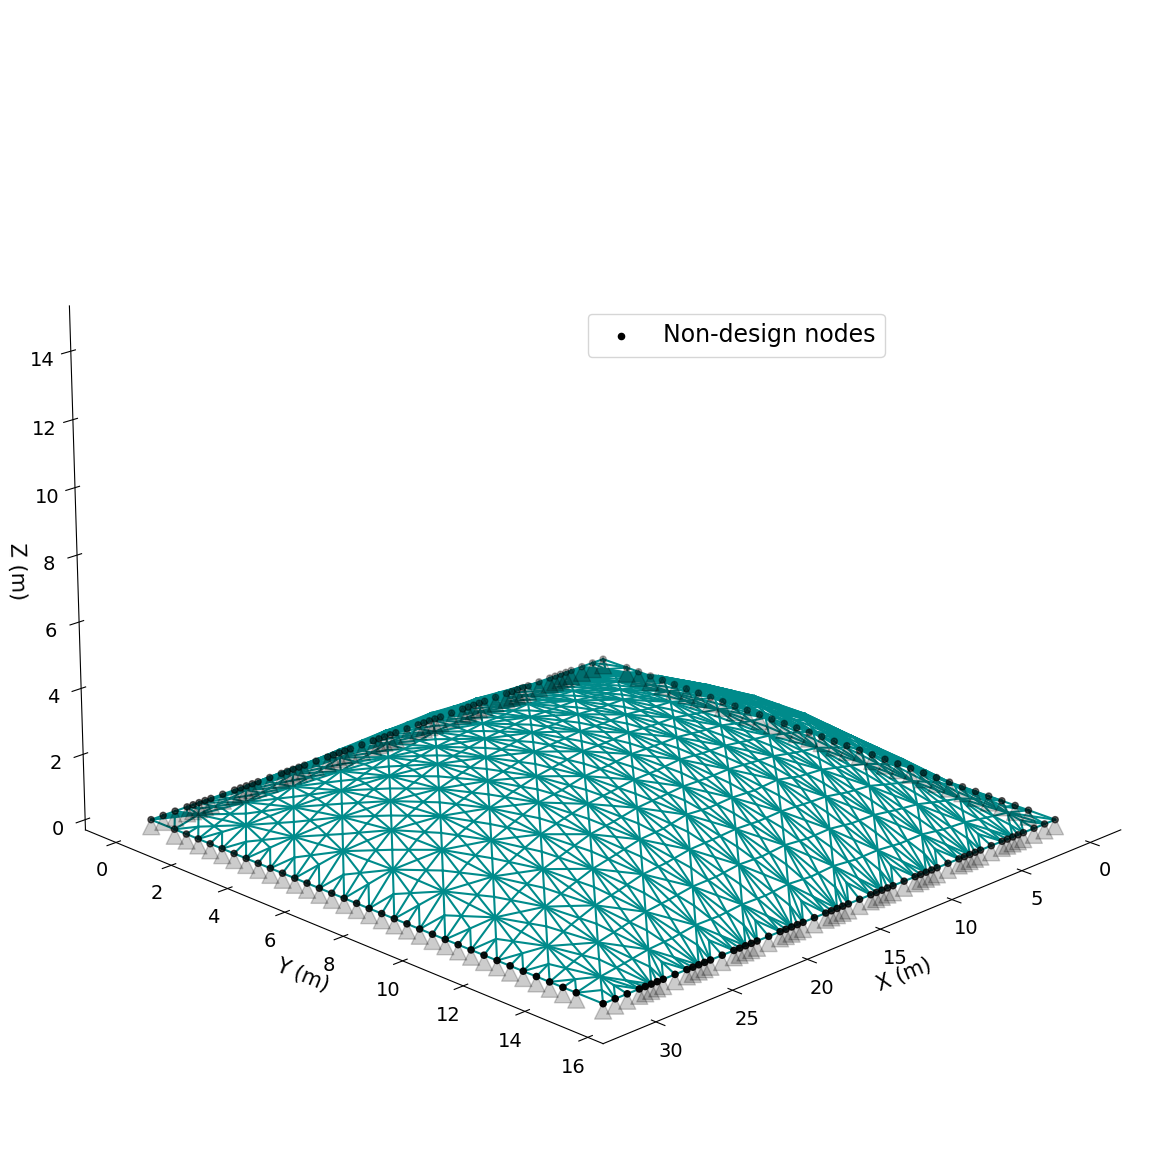

In [63]:

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,15)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, 45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [64]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))
#Matrix storing XY-projected distance  
dx_ij = x_nodes[:,None]-x_nodes[None,:]
dy_ij = y_nodes[:,None]-y_nodes[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,3)


#This does not impose any constraints on the boundary nodes.
#We apply soft constraints - increasing the weights of boundary
alpha = 1 # coefficient adujsting the weights for boundary
B_ij_ini[:,non_design_nodes] *= alpha
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(x_nodes.shape[0]).reshape(x_nodes.shape[0],x_nodes.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [65]:
zs_filtered = z_nodes.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

In [66]:
################
#  SSO MODEL   #
################
#Build the model
#Sectional properties-> 600x400 rectangle
d = 0.1 #diameter
A = np.pi*d**2/4
Iy = np.pi*d**4/64
Iz = np.pi*d**4/64
E = 37900 * 10**5 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
J = Iy + Iz	#Polar moment of inertia
load = 300 #Pt load

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,0,0,1]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

aI = 1e-10
#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,aI*Iy,aI*Iz,aI*J,A) 


In [67]:
A

0.007853981633974483

In [68]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [69]:
%timeit sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)

314 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
C_hist = []
def objective_filter(x,sso_model=sso_model):
    p = z_nodes.copy()
    p[design_nodes]=x
    z = (B_ij@p)[design_nodes]
    sso_model.update_nodeparameter(z) # Update the model
    C,sens = sso_model.value_grad_params(which_solver='dense',enforce_scipy_sparse = True)
    C_hist.append(C)
    return C,np.asarray((sens@B_ij[design_nodes])[design_nodes],dtype=float)#sens_params

In [71]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = sso_model.nodeparameters_values #initial parameters 
opt = optimization.Optimization(n_x,method='GD')
opt.set_objective(objective_filter) #objective function
opt.set_maxiter(200) #max iteration
opt.set_step_size(5e-2) #step size
opt.set_GD_normalized(True) #normalized
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 47801.98377230502
Step 1, objective = 27514.057785302848
Step 2, objective = 22578.18852657167
Step 3, objective = 20263.350666318656
Step 4, objective = 18231.394622052623
Step 5, objective = 17032.366989420087
Step 6, objective = 15698.7605841144
Step 7, objective = 14307.328743353235
Step 8, objective = 13400.167533132919
Step 9, objective = 12264.002543989342
Step 10, objective = 11704.170847786309
Step 11, objective = 10448.923368540738
Step 12, objective = 9968.76946195169
Step 13, objective = 9233.700966198594
Step 14, objective = 8712.057008961838
Step 15, objective = 8212.291911323948
Step 16, objective = 7507.068760928527
Step 17, objective = 6883.572478417473
Step 18, objective = 6315.546646657249
Step 19, objective = 5812.905872894566
Step 20, objective = 5353.782592348946
Step 21, objective = 4909.352407738429
Step 22, objective = 4505.828370046169
Step 23, objective = 4173.05785268655
Step 24, objective = 3922.331392307855
Step 25, objective = 3723.401

In [72]:
z_nodes[design_nodes] = x_opt
zs_filtered = z_nodes.copy()
zs_filtered[design_nodes] =(B_ij@z_nodes)[design_nodes]

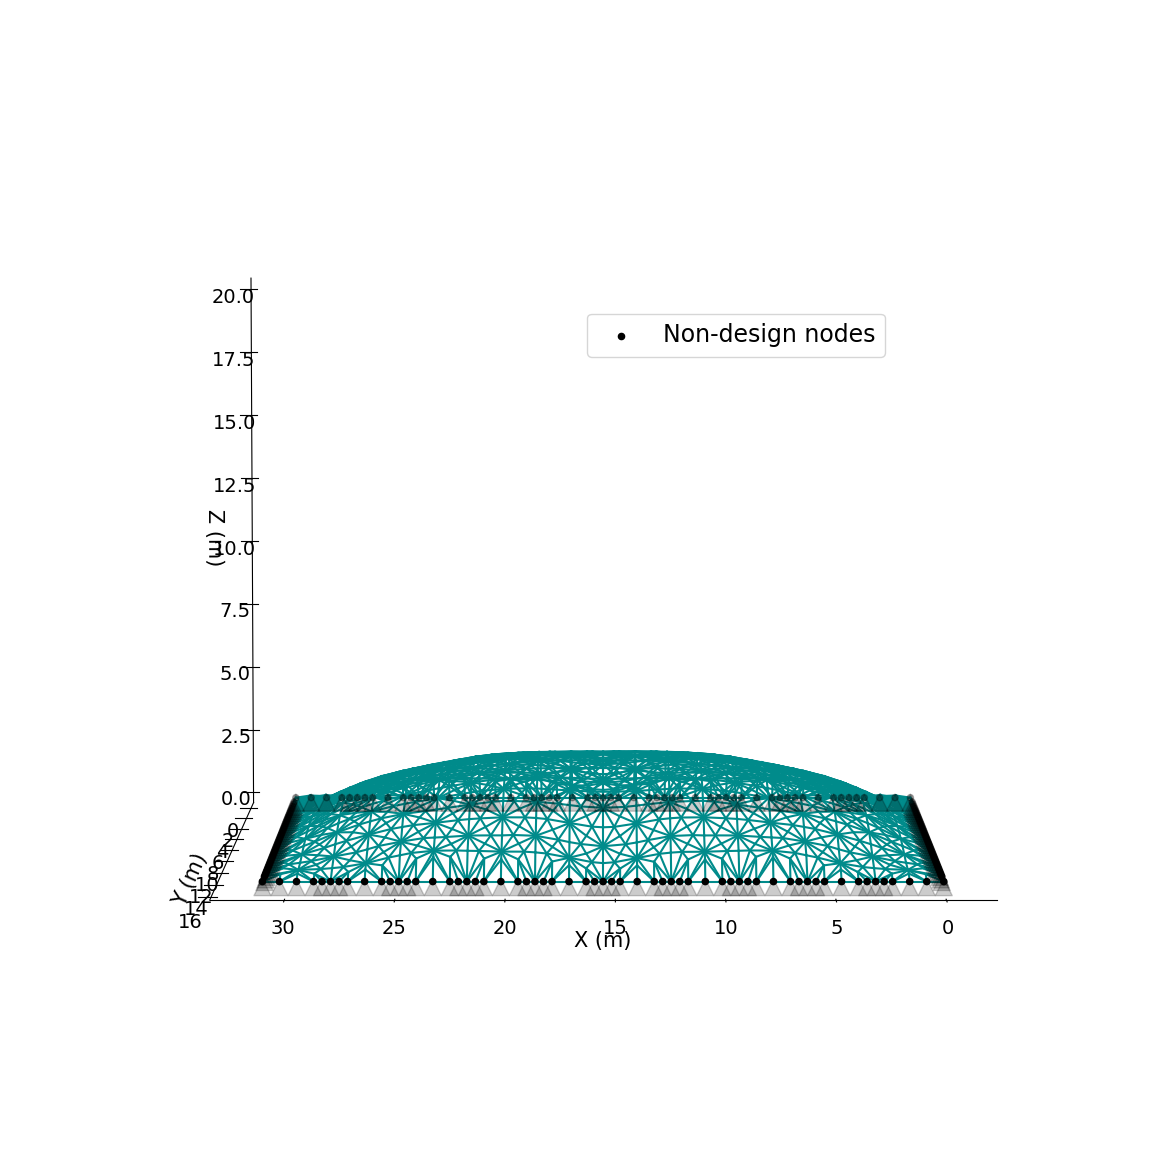

In [73]:
#Update the nodes
%matplotlib inline

z_ele[:,0] = zs_filtered[cnct[:,0]]
z_ele[:,1] = zs_filtered[cnct[:,1]]

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,20)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(5, 90)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [74]:
z_nodes=zs_filtered

In [75]:
################
#  SSO MODEL   #
################
#Build the model
#Sectional properties-> 600x400 rectangle

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    #ai
    a_i = 1e-10
    model.add_beamcol(i,i_node,j_node,E,G,a_i*Iy,a_i*Iz,J,A) 
model.model_ready()
model.solve()
print(model.strain_energy())

1163.0573849259274


In [76]:
np.max(np.abs(model.u[design_nodes*6+2]))

0.057245209125551644

Text(0, 0.5, 'Total strain energy (KN$\\cdot$m)')

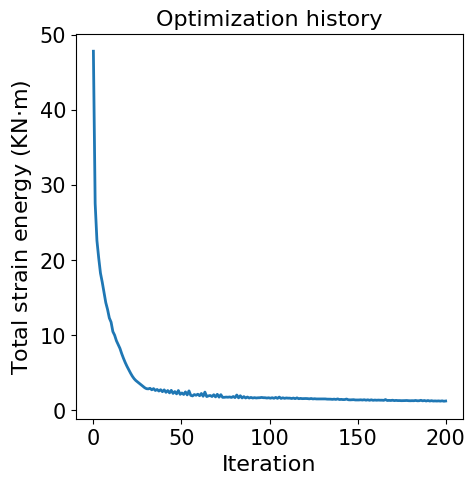

In [77]:


fig, ax = plt.subplots(figsize=(5,5))

plt.plot(np.linspace(0,np.array(C_hist).shape[0],np.array(C_hist).shape[0]),np.array(C_hist)/1000,linewidth=2)
plt.xticks(np.linspace(0,np.array(C_hist).shape[0],5),fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Iteration',fontsize=16)
plt.title('Optimization history',fontsize=16)
plt.ylabel(r'Total strain energy (KN$\cdot$m)',fontsize=16)